In [1]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
import astropy
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
import numpy as np
import cv2
#import ogr
#import shapely.wkt
#import shapely.geometry
import urllib.request
import zipfile
import json
import csv
from collections import Counter
import itertools
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import os, glob
from sklearn import decomposition
from sklearn import cluster
from sklearn import preprocessing
from scipy import spatial
from io import StringIO
import importlib
from mpl_toolkits.mplot3d import Axes3D
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import PIL
from PIL import Image
import scipy.misc

In [2]:
#image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')
image_file = r'C:\USB backup\Sem1, 2019\ENGN8602\sample_data\to_b20061127ut005945s19380.fits.gz'
#image_file = r'E:\T1-Tolar.20061126.asca\net\data\ASCA\20061126\to_b20061127ut000753s16260.fits.gz'
print(image_file)
fits.info(image_file)
image_data = fits.getdata(image_file, ext=0)
#scipy.misc.imsave('C:\\USB backup\\Sem1, 2019\\ENGN8602\\sample_data\\outfile.png', np.log(image_data))

C:\USB backup\Sem1, 2019\ENGN8602\sample_data\to_b20061127ut005945s19380.fits.gz
Filename: C:\USB backup\Sem1, 2019\ENGN8602\sample_data\to_b20061127ut005945s19380.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   


# Issues: 
1. Is the circled area the same for each image? 
2. Which one is better for hourly data, mean or median?
3. Information loss on the normalization (max. and min.) Refer to the next part
4. Memory Error (reshape the image?)

In [3]:
def data_normalization(data): #normalizes data between (0,1)
    new_data = preprocessing.normalize(data)
    return new_data
#investigate the function sent from Charles
def pixel_filter(data): #filters out the round area, set the pixels outside the area to 0
    pixel_width = 940
    centroid = [55+470,35+470]
    r = pixel_width/2
    i,j = data.shape
    mat1 = np.ones([i,j])
    for index in range(i):
        for k in range(j):
            if ((index-centroid[0])**2 + (k-centroid[1])**2) > r**2:
                mat1[index,k] = 0
    return mat1
def read_txt(txt,filename): #reads the txt file, converts the txt file to list
    a = []
    with open(txt, 'r') as f:
        while True:
            line = f.readline() 
            b = line.split()
            a.append(b)
            if not line:
                return a
                break     
                
def convert_label(label): #tokenize the labels
    if label == 'n':  
        out = 0
    elif label == 'm':
        out = 1
    elif label == 'o':
        out = 2
    elif label == 'p':
        out = 3
    elif label == 'i':
        out = 4
    elif label == 'u':
        out = 5
    else:
        out = 6
    return out
def get_hourly_mean1(rootDir,hour): #calculates the mean data hourly, outputs the blue and red band data
    list_dirs = os.walk(rootDir)
    a = ''
    cnt1 = 0
    cnt2 = 0
    data1 = np.zeros([256,256])
    data2 = np.zeros([256,256])
    for root, dirs, files in list_dirs: 
        for d in files: 
            path = os.path.join(root, d)
            str0 = path.split('\\')[-1]
            str1 = str0[3]
            str2 = str0[14]+str0[15]
            
            if str1 == "b":
                if str2 == hour:
                    cnt1 += 1
                    image_file = path
                    #fits.info(image_file)
                    
                    image_data = fits.getdata(image_file, ext=0)
                    
                    #image_data = data_normalization(np.log(image_data))
                    if image_data.shape[0] != 1024:
                        cnt1 -=1
                        continue
                    else:
                        image_data = cv2.resize(image_data,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_CUBIC)
                        data1 = data1 + image_data
                    
                    #print(np.max(data1))
                    
            elif str1 == "r":
                if str2 == hour:
                    cnt2 += 1
                    image_file = path
                    #fits.info(image_file)
                    
                    image_data = fits.getdata(image_file, ext=0)
                    
                    #image_data = data_normalization(np.log(image_data))
                    if image_data.shape[0] != 1024:
                        cnt2 -= 1
                        continue
                    else:
                        image_data = cv2.resize(image_data,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_CUBIC)
                        data2 = data2 + image_data
                        
            #print(str)
    if cnt1 * cnt2 == 0:
        data1 = np.zeros([256,256])
        data2 = np.zeros([256,256])
        return data1,data2
    print(cnt1,cnt2)
    data1 = data1/cnt1
    data2 = data2/cnt2
    print(data1)
    data1 = data_normalization(data1)
    data2 = data_normalization(data2)
    return data1, data2
def get_hourly_mean(rootDir,hour): #calculates the mean data hourly, outputs the blue and red band data
    list_dirs = os.walk(rootDir)
    a = ''
    cnt1 = 0
    cnt2 = 0
    data1 = np.zeros([1024,1024])
    data2 = np.zeros([1024,1024])
    for root, dirs, files in list_dirs: 
        for d in files: 
            path = os.path.join(root, d)
            str0 = path.split('\\')[-1]
            str1 = str0[3]
            str2 = str0[14]+str0[15]
            
            if str1 == "b":
                if str2 == hour:
                    cnt1 += 1
                    image_file = path
                    fits.info(image_file)
                    image_data = fits.getdata(image_file, ext=0)
                    #image_data = data_normalization(np.log(image_data))
                    data1 = data1 + image_data
                    
            elif str1 == "r":
                if str2 == hour:
                    cnt2 += 1
                    image_file = path
                    fits.info(image_file)
                    image_data = fits.getdata(image_file, ext=0)
                    #image_data = data_normalization(np.log(image_data))
                    data2 = data2 + image_data
            #print(str)
    data1 = data1/cnt1
    data2 = data2/cnt2
    data1 = data_normalization(np.log(data1))
    data2 = data_normalization(np.log(data2))
    return data1, data2    
def data_reshape(txtlist): #reshapes the data and restructure all data in the list. data: n*d, label: n*1
    num_data = len(txtlist)
    print(num_data)
    data_b = np.zeros([num_data,1024*1024])
    data_r = np.zeros([num_data,1024*1024])
    label_out = np.zeros(num_data)
    for i in range (num_data):
        str0 =  ''.join(txtlist[i][0:3])
        dir0 = image_folder + "\\" + str0
        hour =  ''.join(txtlist[i][3])
        label = ''.join(txtlist[i][4])
        label = convert_label(label)
        label_out[i] = label
        data1,data2 = get_hourly_mean(dir0,hour)
        data1 = pixel_filter(data1)*data1
        data2 = pixel_filter(data2)*data2
        data1 = np.reshape(data1, 1024*1024)
        data2 = np.reshape(data2, 1024*1024)
        data_b[i][:] = data1
        data_r[i][:] = data2
    return data_b,data_r,label_out
def data_organizer1(txtlist): #reshapes the data and restructure all data in the list. data: d*n label: n*1
    num_data = len(txtlist)
 #   print(num_data)
    data_bC = np.zeros([num_data,256*256])
    data_rC = np.zeros([num_data,256*256])
#     print(np.shape(data_bC))
#     data_bR = np.zeros([np.shape(Loc_R)[0],num_data])
#     data_rC = np.zeros([np.shape(Loc_C)[0],num_data])
#     data_rR = np.zeros([np.shape(Loc_R)[0],num_data])
    label_out = np.zeros(num_data)
    for i in range (num_data):
        print(i)
        str0 =  ''.join(txtlist[i][0:3])
        dir0 = image_folder + "\\" + str0
        hour =  ''.join(txtlist[i][3])
        label = ''.join(txtlist[i][4])
        label = convert_label(label)
        label_out[i] = label
        data1,data2 = get_hourly_mean1(dir0,hour)
        data_bC[i,:] = data1.reshape((1,256*256))
        data_rC[i,:] = data2.reshape((1,256*256))
    return data_bC,data_rC,label_out
#         data_bR[:,i] = data1R_sum
#         data_rC[:,i] = data2C_sum
#         data_rR[:,i] = data2R_sum
#     return data_bC,data_bR,data_rC,data_rR,label_out
#def get_next_data(txtlist,Loc_C,Loc_R,i)   

In [4]:
print(len(b[0]))
print(b[0][1])
print(b[len(b)-1])
a = [[1,2,3],[4,5,6]]
a[0][:] = [5,5,5]
print(a[0][:])

NameError: name 'b' is not defined

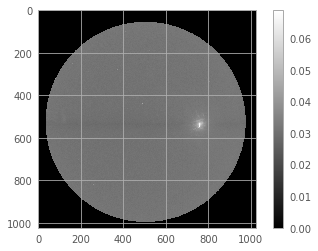

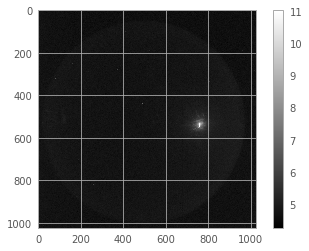

In [35]:
i,j = image_data.shape
a = np.ones([i,j])
mat = pixel_filter(image_data)
plt.figure()
plt.imshow(data_normalization(np.log(image_data))*mat, cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(np.log(image_data), cmap='gray')
plt.colorbar()

In [38]:
image_folder = 'D:\TMT_DATA_2\T2-Armazones'
txt = r'D:\TMT_DATA_2\T2-Armazones\newlist.txt'
#def get_data_array(root_dir,txt):
b = read_txt(txt,image_folder)
b.remove(b[0])
b.remove(b[-1])
str0 =  ''.join(b[0][0:3])
dir0 = image_folder + "\\" + str0
print(dir0)
hour =  ''.join(b[0][3])
print(hour)
data1, data2 = get_hourly_mean(dir0,hour)
#a = np.zeros([5000,1024*1024])
data_b,data_r,label_out = data_organizer1(b)
#img = img.resize((width, height),Image.ANTIALIAS)

D:\TMT_DATA_2\T2-Armazones\20070614
08
Filename: D:\TMT_DATA_2\T2-Armazones\20070614\ar_b20070615ut080105s05640.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: D:\TMT_DATA_2\T2-Armazones\20070614\ar_b20070615ut080504s05880.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: D:\TMT_DATA_2\T2-Armazones\20070614\ar_b20070615ut080903s06120.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: D:\TMT_DATA_2\T2-Armazones\20070614\ar_b20070615ut081303s06360.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: D:\TMT_DATA_2\T2-Armazones\2007

(400, 2)


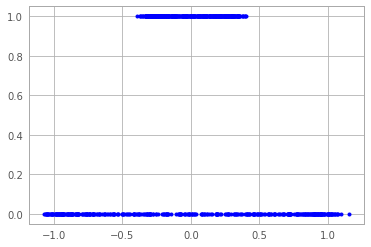

In [10]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=400, factor=.3, noise=.05)
print(X.shape)
plt.plot(X,y,'b.')

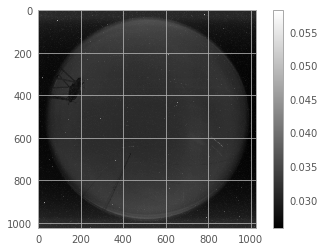

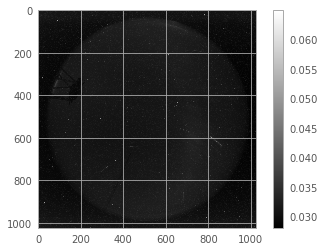

In [39]:
#data1 = pixel_filter(data1)
plt.figure()
plt.imshow(data2, cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(data1, cmap='gray')
plt.colorbar()

In [28]:
print(b)

[['2005', '10', '20', '00', 'n'], ['2005', '10', '20', '01', 'm'], ['2005', '10', '20', '02', 'm'], ['2005', '10', '20', '03', 'm'], ['2005', '10', '20', '04', 'm'], ['2005', '10', '20', '05', 'm'], ['2005', '10', '20', '06', 'm'], ['2005', '10', '20', '07', 'm'], ['2005', '10', '20', '08', 'm'], ['2005', '10', '20', '09', 'm'], ['2005', '10', '20', '23', 'p'], ['2005', '10', '21', '00', 'p'], ['2005', '10', '21', '01', 'p'], ['2005', '10', '21', '02', 'm'], ['2005', '10', '21', '03', 'm'], ['2005', '10', '21', '04', 'm'], ['2005', '10', '21', '05', 'm'], ['2005', '10', '21', '06', 'm'], ['2005', '10', '21', '07', 'm'], ['2005', '10', '21', '08', 'm'], ['2005', '10', '21', '09', 'm'], ['2005', '10', '21', '23', 'm'], ['2005', '10', '22', '00', 'p'], ['2005', '10', '22', '01', 'p'], ['2005', '10', '22', '02', 'p'], ['2005', '10', '22', '03', 'm'], ['2005', '10', '22', '04', 'm'], ['2005', '10', '22', '05', 'm'], ['2005', '10', '22', '06', 'm'], ['2005', '10', '22', '07', 'm'], ['2005', 

In [32]:
%matplotlib inline

clouds_as_arrays = a
pca = decomposition.KernelPCA(n_components=3, kernel='linear')
pca_fit = pca.fit_transform(preprocessing.scale(clouds_as_arrays))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2])
ax.set_title('PCA - Plotting first 3 Components')
plt.show()


pca = decomposition.KernelPCA(n_components=3, kernel='poly')
pca_fit = pca.fit_transform(preprocessing.scale(clouds_as_arrays))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2])
ax.set_title('kPCA with Polynomial Kernel - 3 Components')
plt.show()


pca = decomposition.KernelPCA(n_components=3, kernel='rbf')
pca_fit = pca.fit_transform(preprocessing.scale(clouds_as_arrays))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2])
ax.set_title('kPCA with Radial Basis Function Kernel -3 Components')
plt.show()

KeyboardInterrupt: 

In [11]:
%matplotlib inline

clouds_as_arrays = a
pca = decomposition.KernelPCA(n_components=3, kernel='linear')
pca_fit = pca.fit_transform(preprocessing.scale(clouds_as_arrays))

In [20]:
def get_png(rootDir,hour,str0): #calculates the mean data hourly, outputs the blue and red band data
    list_dirs = os.walk(rootDir)
    a = ''
    cnt1 = 0
    cnt2 = 0
    data1 = np.zeros([1024,1024])
    data2 = np.zeros([1024,1024])
    for root, dirs, files in list_dirs: 
        for d in files: 
            path = os.path.join(root, d)
            str0 = path.split('\\')[-1]
            str1 = str0[3]
            date = str0[]
            str2 = str0[14]+str0[15]
            
            if str1 == "b":
                if str2 == hour:
                    cnt1 += 1
                    image_file = path
                    fits.info(image_file)
                    image_data = fits.getdata(image_file, ext=0)
                    #image_data = data_normalization(np.log(image_data))
                    data1 = data1 + image_data
                    
            elif str1 == "r":
                if str2 == hour:
                    cnt2 += 1
                    image_file = path
                    fits.info(image_file)
                    image_data = fits.getdata(image_file, ext=0)
                    tmp = 'E:\\Test_Data\\' + str0 + str(cnt2) +'.png'
                    scipy.misc.imsave(tmp, np.log(image_data))
                    #image_data = data_normalization(np.log(image_data))
                    data2 = data2 + image_data
            #print(str)
    data1 = data1/cnt1
    data2 = data2/cnt2
    tmp = 'E:\\Test_Data\\b'+ str0 + str(hour) +'.png'
    scipy.misc.imsave(tmp,data1)
    data1 = data_normalization(np.log(data1))
    data2 = data_normalization(np.log(data2))
    return data1, data2  

In [ ]:
# location for each of the classes: 885，65，54，11，1，0

In [32]:
image_folder = 'E:\TMT_DATA_2\T2-Armazones'
txt = r'E:\TMT_DATA_2\T2-Armazones\usability_T2-Armazones_200510_200802_COMBINED .txt'
#def get_data_array(root_dir,txt):
b = read_txt(txt,image_folder)
b.remove(b[0])
b.remove(b[-1])
str0 =  ''.join(b[14][0:3])
dir0 = image_folder + "\\" + str0
print(dir0)
hour =  ''.join(b[14][3])
print(hour)
data1,data2 = get_png(dir0,hour,str0)
#a = np.zeros([5000,1024*1024])
#data_b,data_r,label_out = data_reshape(b)
#img = img.resize((width, height),Image.ANTIALIAS)

E:\TMT_DATA_2\T2-Armazones\20051021
03
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_b20051022ut030753s18630.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_b20051022ut031022s18780.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_b20051022ut031222s18900.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_b20051022ut031421s19020.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\2005

c:\users\tony\anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_r20051022ut030852s18690.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_r20051022ut031052s18810.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_r20051022ut031252s18930.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_r20051022ut031451s19050.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
Filename: E:\TMT_DATA_2\T2-Armazones\20051021\ar_r20051022ut031651s19170.fits.gz

In [11]:
print(b)

[['2005', '10', '20', '00', 'n'], ['2005', '10', '20', '01', 'm'], ['2005', '10', '20', '02', 'm'], ['2005', '10', '20', '03', 'm'], ['2005', '10', '20', '04', 'm'], ['2005', '10', '20', '05', 'm'], ['2005', '10', '20', '06', 'm'], ['2005', '10', '20', '07', 'm'], ['2005', '10', '20', '08', 'm'], ['2005', '10', '20', '09', 'm'], ['2005', '10', '20', '23', 'p'], ['2005', '10', '21', '00', 'p'], ['2005', '10', '21', '01', 'p'], ['2005', '10', '21', '02', 'm'], ['2005', '10', '21', '03', 'm'], ['2005', '10', '21', '04', 'm'], ['2005', '10', '21', '05', 'm'], ['2005', '10', '21', '06', 'm'], ['2005', '10', '21', '07', 'm'], ['2005', '10', '21', '08', 'm'], ['2005', '10', '21', '09', 'm'], ['2005', '10', '21', '23', 'm'], ['2005', '10', '22', '00', 'p'], ['2005', '10', '22', '01', 'p'], ['2005', '10', '22', '02', 'p'], ['2005', '10', '22', '03', 'm'], ['2005', '10', '22', '04', 'm'], ['2005', '10', '22', '05', 'm'], ['2005', '10', '22', '06', 'm'], ['2005', '10', '22', '07', 'm'], ['2005', 